# Dowhy - Estimation
- Estimation 방식에 대해서 알아보자.

In [1]:
!pip install dowhy
# pygraphviz install 
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.3 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 5 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,

In [2]:
import numpy as np
import pandas as pd
import os, sys
import dowhy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# causal effect 를 추정하고자 하는 데이터 generation 
- Causal Effect 를 추정하고자 하는 Sample - Data 를 Generation 해봅시다.

In [22]:
rvar = 1 if np.random.uniform() >0.5 else 0
from dowhy import datasets
data_dict = datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_samples=10000,
        num_treatments=1,
        treatment_is_binary=True,
        outcome_is_binary=False,
        stddev_treatment_noise=10)
df = data_dict["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.956317,-0.066909,1.366132,1.409004,-0.632100,-0.202233,True,13.582537
1,1.0,0.030157,0.556370,-0.585984,1.258902,-1.406943,-1.601430,False,1.100164
2,0.0,0.419115,-0.481081,-0.128692,-0.035902,0.107737,-0.909356,False,-2.341952
3,0.0,0.157527,-0.136562,1.504180,2.272688,1.378378,-1.549043,True,15.991616
4,1.0,0.200087,0.551441,0.548785,0.107690,0.245070,-0.669709,True,10.460468
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.030456,-0.225640,0.733386,1.534218,-0.240193,-0.459841,False,3.629894
9996,1.0,0.596907,0.182091,1.229971,-2.393867,-0.313953,-2.602986,True,-1.913167
9997,1.0,0.768440,0.113774,1.843182,0.621269,0.358226,-0.936089,True,11.121635
9998,0.0,0.315771,-0.448194,0.643095,0.296290,1.982599,-0.603174,True,11.099483


In [4]:
data_dict["dot_graph"]

'digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;}'

In [5]:
# With graph
model=dowhy.CausalModel(
        data = df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        graph=data_dict["gml_graph"],
        instruments=data_dict["instrument_names"]
        )

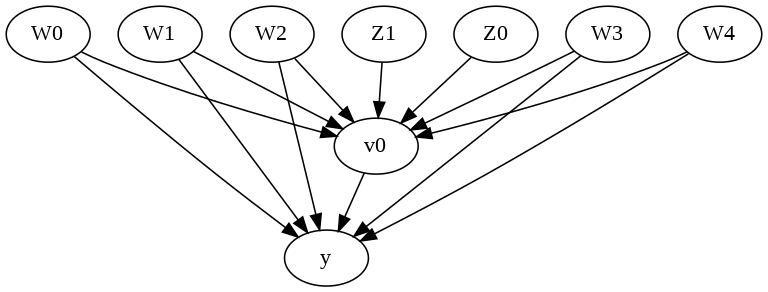

In [6]:
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
# Identification 을 보면 Backdoor 또는 IV 를 추천 
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Estimation

## backdoor.linear_regression
- backdoor estimation 으로 linear regression 을 사용한다.


### Continuous Y

In [35]:
# Linear Regression : 단순 Linear Regression 을 이용함. 
# feature로는 backdoor-adjustment-set 을 사용함
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: ate

## Estimate
Mean value: 7.1818501200635385
p-value: [0.]

Causal Estimate is 7.1818501200635385


### Binary Y

In [36]:
# y - target 이 count / binary 등이여서 GLM 을 사용할 필요성이 있을경우 아래처럼 사용함. 
# GLM 을 이용하여서 y target 추정할때에 사용
# y - target 의 생김새에 따라서 다양한 famlily 를 넣으면 된다.

import statsmodels.api
df_new = df.copy()
df_new["y"] = (df_new["y"] > 0.5)*1. 
model2=dowhy.CausalModel(
        data = df_new,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        graph=data_dict["gml_graph"],
        instruments=data_dict["instrument_names"]
        )

causal_estimate_reg = model2.estimate_effect(identified_estimand,
        method_name="backdoor.generalized_linear_model",
        method_params = {"glm_family" : statsmodels.api.families.Binomial()})
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

generalized_linear_model


/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~Sigmoid(v0+W3+W4+W1+W0+W2)
Target units: ate

## Estimate
Mean value: 0.36369738866901025

Causal Estimate is 0.36369738866901025


/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  y * np.log(mu / (1 - mu + 1e-20)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in multiply
  y * np.log(mu / (1 - mu + 1e-20)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


### Count Y

In [37]:
# GLM 을 이용하여서 y target 추정할때에 사용
# y - target 의 생김새에 따라서 다양한 famlily 를 넣으면 된다.

import statsmodels.api
df_new = df.copy()
df_new["y"] = round(abs(df_new["y"]))
model2=dowhy.CausalModel(
        data = df_new,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        graph=data_dict["gml_graph"],
        instruments=data_dict["instrument_names"]
        )

causal_estimate_reg = model2.estimate_effect(identified_estimand,
        method_name="backdoor.generalized_linear_model",
        method_params = {"glm_family" : statsmodels.api.families.Poisson()})
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

generalized_linear_model
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~Sigmoid(v0+W3+W4+W1+W0+W2)
Target units: ate

## Estimate
Mean value: 8.374805841468117

Causal Estimate is 8.374805841468117


## backdoor.distance_matching

In [38]:
# distance_matching 으로, metric 은 minkowski 를 사용가능. 다른것도 사용가능하지만, 사실상 minkowski 정도로도 충분함!
# num_mathce_per_unit 은 match 되는 unit 을 몇개나 설정할지임. 당연히 default 는 1임
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2 , "num_matches_per_unit":3},
                                              )
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

distance_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: att

## Estimate
Mean value: 9.059660118114952

Causal Estimate is 9.059660118114952


## backdoor.propensity_score_stratification

In [39]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

propensity_score_stratification


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: att

## Estimate
Mean value: 7.979736930187871

Causal Estimate is 7.979736930187871


## backdoor.propensity_score_matching

In [40]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: atc

## Estimate
Mean value: 6.856136230182032

Causal Estimate is 6.856136230182032


## backdoor.propensity_score_weighting

### ips_stabilized_weight

In [41]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_stabilized_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: ate

## Estimate
Mean value: 8.622659022040331

Causal Estimate is 8.622659022040331


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### ips_weight

In [42]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W1,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W1,W0,W2,U) = P(y|v0,W3,W4,W1,W0,W2)

## Realized estimand
b: y~v0+W3+W4+W1+W0+W2
Target units: ate

## Estimate
Mean value: 8.62265902204033

Causal Estimate is 8.62265902204033


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## instrumental_variable

In [47]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': ['Z0']})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

instrumental_variable
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in th

## Regression Discontinuiuty
- Fuzzy 기반인듯

In [48]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity",
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.15})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

regression_discontinuity
      local_rd_variable  local_treatment  local_outcome
2              0.419115            False            2.0
6              0.446403            False            1.0
10             0.526459             True           13.0
13             0.382187             True           14.0
19             0.442324             True            9.0
...                 ...              ...            ...
9985           0.533052             True           22.0
9987           0.573684             True           16.0
9988           0.457756            False            0.0
9990           0.597013             True           12.0
9996           0.596907             True            2.0

[3071 rows x 3 columns]
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estim